In [1]:
import os
import pandas as pd
import numpy as np
import string

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
corpus = pd.read_csv('corpus.csv', header=None, names=['message'])

In [4]:
#Creating an extensive list of stop words to remove prior to any sort of analysis

In [5]:
from sklearn.feature_extraction import _stop_words
import nltk
from nltk.corpus import stopwords

nopuncwords = []
for word in stopwords.words('english'):
    nopunc = word.translate(str.maketrans('', '', string.punctuation))
    nopuncwords.append(word)
    if word != nopunc:
        nopuncwords.append(word.translate(str.maketrans('', '', string.punctuation)))

In [6]:
sklearnwords = []
for word in _stop_words.ENGLISH_STOP_WORDS:
    sklearnwords.append(word)

In [7]:
#Adding some of the most frequent words in the corpus that have little semantic content

In [8]:
corpus['tokens'] = corpus['message'].str.split(' ')

words = []
for i in range(corpus.shape[0]):
    message_length = len(corpus['tokens'].iloc[i])
    for j in range(message_length):
        words.append(corpus['tokens'].iloc[i][j])

cleanwords = []
for word in words:
    word = word.lower()
    word = word.translate(str.maketrans('', '', string.punctuation))
    cleanwords.append(word)

In [9]:
word_df = pd.DataFrame(cleanwords[0].split(), columns=['token'])
freq = word_df.value_counts().rename_axis('token').reset_index(name='counts')

In [10]:
stopwords2 = 'i, the, you, a, to, u, my, it, is, me, do, im, and, for, are, like, so, that, in, have, what, no, on, of, we, dont, get, hi, be, but, its, not, he,was, yes, can, ok, got, how, they, why, with, this, ur, thats, she, your,at, if, will, did, too, more, oh, yeah, when, am, wanna, them, ill, or,some, out, hey, where, whats, lets, then, cant, from, there, still, her, him,us, were, gonna, much, been, about, could, any, youre, would, shes, hes,  should, would, could, had, his, our, off, tho, as, ye, r, does, doing, did, ya, ive, than, okay, rn, has, an, mine, us, havent, ago, yo, isnt, doesnt,being, while, by, bc, hello, nah, though, done, whos, wont, didnt, having, cuz, went'
stopwords_list = stopwords2.split(',')

trimmed_sw = []
for word in stopwords_list:
    trimmed_sw.append(word.strip())

In [11]:
stopwords = nopuncwords + sklearnwords + trimmed_sw

In [12]:
#LDA analysis

In [13]:
#LDA depends on word count probabilities, so we use CountVectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
cv = CountVectorizer(stop_words=stopwords)

In [16]:
dtm = cv.fit_transform(corpus['message'])

In [17]:
#Attempting to group into 10 topics
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, random_state=114)

In [18]:
lda.fit(dtm)

LatentDirichletAllocation(random_state=114)

In [19]:
#Top 20 words for each topic
for i, topic in enumerate(lda.components_):
    print(f"Top 20 words for topic #{i+1}:")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-20:]])
    print('\n')

Top 20 words for topic #1:
['dentist', 'hard', 'mouse', 'make', 'shoes', 'use', 'speak', 'sweet', 'quack', 'baby', 'drip', 'castle', 'maybe', 'xd', 'ima', 'bored', 'remember', 'gags', 'ty', 'lol']


Top 20 words for topic #2:
['stay', 'things', 'long', 'funny', 'glad', 'hq', 'left', 'group', 'great', 'sad', 'missed', 'building', 'eat', 'look', 'doodle', 'add', 'new', 'game', 'friend', 'want']


Top 20 words for topic #3:
['bet', 'works', 'tyvm', 'law', 'maxed', 'look', 'loud', 'jellybeans', 'work', 'gamer', 'let', 'cfo', 'tysm', 'come', 'real', 'guys', 'mean', 'toons', 'omg', 'toon']


Top 20 words for topic #4:
['jelly', 'bruno', 'wrong', 'plz', 'problem', 'vp', 'wow', 'guy', 'long', 'poor', 'woof', 'talking', 'hat', 'bye', 'pls', 'sorry', 'wait', 'nice', 'say', 'beans']


Top 20 words for topic #5:
['gabby', 'turn', 'caught', 'hate', 'thing', 'cj', 'mom', 'toons', 'legs', 'fight', 'muted', 'big', 'mad', 'dang', 'green', 'said', 'fun', 'help', 'know', 'good']


Top 20 words for topic 

In [20]:
#Not particularly informative
#No cohesive topics to be found - very interesting mix of quite specific words and 
#broad, general words

In [21]:
topic_results = lda.transform(dtm)

In [22]:
corpus['LDA topic'] = (topic_results.argmax(axis=1)+1)

In [23]:
#Calculating some metrics
corpus['wordlength'] = corpus['tokens'].apply(len)
corpus['charlength'] = corpus['message'].apply(len)

In [24]:
#Calculating polarities
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [25]:
corpus['scores'] = corpus['message'].apply(analyzer.polarity_scores)

In [26]:
def get_analysis(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [27]:
compounds = []
for i in range(len(corpus)):
    compounds.append(corpus['scores'].iloc[i]['compound'])
corpus['compounds'] = compounds
corpus['polarity'] = corpus['compounds'].apply(get_analysis)
corpus.drop(columns=['compounds', 'scores'], inplace=True)

In [28]:
#Getting some metrics to perform visualization

In [29]:
wordlen_mean = dict.fromkeys(range(1,11))
wordlen_std = dict.fromkeys(range(1,11))
charlen_mean = dict.fromkeys(range(1,11))
charlen_std = dict.fromkeys(range(1,11))

In [30]:
for i in range(1,11):
    wordlen_mean[i] = corpus[corpus['LDA topic'] == i].describe()['wordlength']['mean']
wordmeans = list(wordlen_mean.values())
    
for i in range(1,11):
    wordlen_std[i] = corpus[corpus['LDA topic'] == i].describe()['wordlength']['std']
wordstds = list(wordlen_std.values())

for i in range(1,11):
    charlen_mean[i] = corpus[corpus['LDA topic'] == i].describe()['charlength']['mean']
charmeans = list(charlen_mean.values())
    
for i in range(1,11):
    charlen_std[i] = corpus[corpus['LDA topic'] == i].describe()['charlength']['std']
charstds = list(charlen_std.values())

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
metrics = pd.DataFrame({'topic':np.arange(1,11),
                               'word len mean': wordmeans,
                              'word len std': wordstds,
                              'char len mean': charmeans,
                              'char len std': charstds},
                             index=np.arange(1,11))

topics = range(1,11)
means = metrics['word len mean'].values
sd = metrics['word len std'].values
char = metrics['char len mean'].values
charsd = metrics['char len std'].values

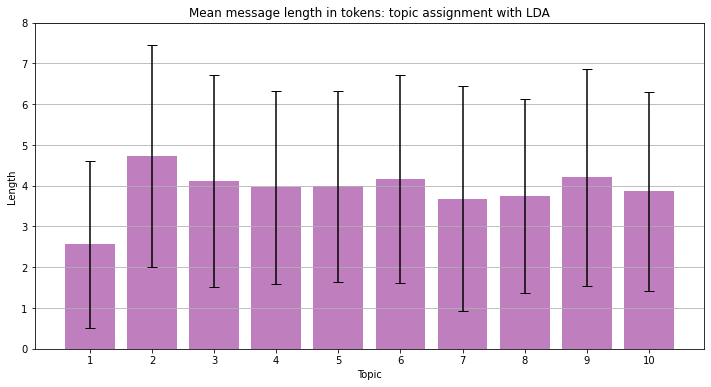

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(1,11), means, color='Purple', ecolor='Black', yerr=sd, alpha=0.5, width=0.8, capsize=5)
ax.set_xticks(topics)
ax.set_yticks(np.arange(0,9))
ax.set_title('Mean message length in tokens: topic assignment with LDA')
ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.yaxis.grid(True);

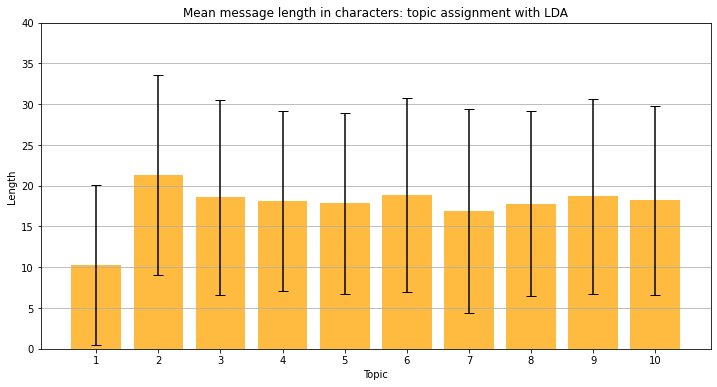

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(1,11), char, color='Orange', ecolor='Black', yerr=charsd, alpha=0.75, width=0.8, capsize=5)
ax.set_xticks(topics)
ax.set_yticks(np.arange(0,41,5))
ax.set_title('Mean message length in characters: topic assignment with LDA')
ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.yaxis.grid(True);

In [35]:
polarities = corpus.drop(columns=['message', 'tokens', 'wordlength', 'charlength'])

In [36]:
palette1 = sns.color_palette(['#68966b', '#7b9ded', '#c46e6e'])

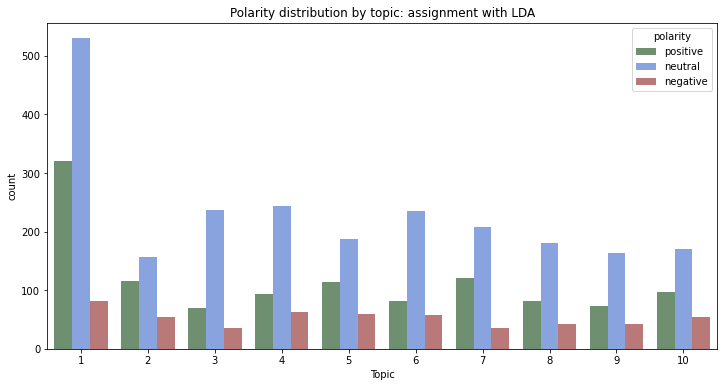

In [37]:
plt.figure(figsize=(12,6))
sns.countplot(data=polarities, x='LDA topic', hue='polarity', 
              hue_order=['positive', 'neutral', 'negative'], palette=palette1)
plt.title('Polarity distribution by topic: assignment with LDA')
plt.xlabel('Topic');

In [38]:
#Nothing jumps out except for the much higher frequency of messages assigned to topic 1
#and given the seeming randomness / lack of cohesion of the top words in 
#each topic, I don't know why so many messages ended up in topic 1

In [39]:
#NMF analysis

In [40]:
#We use tfidf vectorization because we use coefficients for NMF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
#trying to strike a balance between terms that are overly unique and those that are overly frequent
tfidf = TfidfVectorizer(max_df=0.95, min_df=4, stop_words=stopwords)

In [43]:
dtm_nmf = tfidf.fit_transform(corpus['message'])

In [44]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=10, random_state=114)

In [45]:
nmf.fit(dtm_nmf)

/Users/ethancz/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=10, random_state=114)

In [46]:
for index, topic in enumerate(nmf.components_):
    print(f"Top 20 words for topic {index+1}:")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

Top 20 words for topic 1:
['sis', 'heck', 'yw', 'wow', 'bruh', 'muted', 'rip', 'eat', 'sure', 'tell', 'cool', 'time', 'new', 'going', 'thing', 'sweet', 'trolley', 'idk', 'know', 'lol']


Top 20 words for topic 2:
['guys', 'toons', 'follow', 'know', 'ppl', 'away', 'jelly', 'real', 'throw', 'time', 'drop', 'say', 'jump', 'love', 'plz', 'wants', 'poor', 'want', 'pls', 'beans']


Top 20 words for topic 3:
['omg', 'thought', 'turn', 'mad', 'yall', 'funny', 'duck', 'gotta', 'help', 'friend', 'plz', 'super', 'paige', 'papa', 'castle', 'phil', 'hope', 'sweet', 'real', 'ty']


Top 20 words for topic 4:
['bored', 'change', 'look', 'tysm', 'people', 'told', 'toontown', 'great', 'says', 'miss', 'person', 'dang', 'kind', 'ugh', 'guys', 'wow', 'dad', 'alright', 'million', 'thanks']


Top 20 words for topic 5:
['cog', 'pet', 'shirt', 'maxed', 'laff', 'rip', 'lvl', 'care', 'friends', 'trolley', 'cogs', 'fish', 'people', '12', 'game', 'help', 'jellybeans', 'doodle', 'gags', 'need']


Top 20 words for t

In [47]:
topic = nmf.transform(dtm_nmf)

In [48]:
corpus['NMF topic'] = (topic.argmax(axis=1)+1)

In [49]:
#Checking out metrics again

In [50]:
wordlen_mean2 = dict.fromkeys(range(1,11))
wordlen_std2 = dict.fromkeys(range(1,11))
charlen_mean2 = dict.fromkeys(range(1,11))
charlen_std2 = dict.fromkeys(range(1,11))

In [51]:
for i in range(1,11):
    wordlen_mean2[i] = corpus[corpus['NMF topic'] == i].describe()['wordlength']['mean']
wordmeans2 = list(wordlen_mean2.values())
    
for i in range(1,11):
    wordlen_std2[i] = corpus[corpus['NMF topic'] == i].describe()['wordlength']['std']
wordstds2 = list(wordlen_std2.values())

for i in range(1,11):
    charlen_mean2[i] = corpus[corpus['NMF topic'] == i].describe()['charlength']['mean']
charmeans2 = list(charlen_mean2.values())
    
for i in range(1,11):
    charlen_std2[i] = corpus[corpus['NMF topic'] == i].describe()['charlength']['std']
charstds2 = list(charlen_std2.values())

In [52]:
metrics2 = pd.DataFrame({'topic':np.arange(1,11),
                               'word len mean': wordmeans2,
                              'word len std': wordstds2,
                              'char len mean': charmeans2,
                              'char len std': charstds2},
                             index=np.arange(1,11))

topics = range(1,11)
means2 = metrics['word len mean'].values
sd2 = metrics['word len std'].values
char2 = metrics['char len mean'].values
charsd2 = metrics['char len std'].values

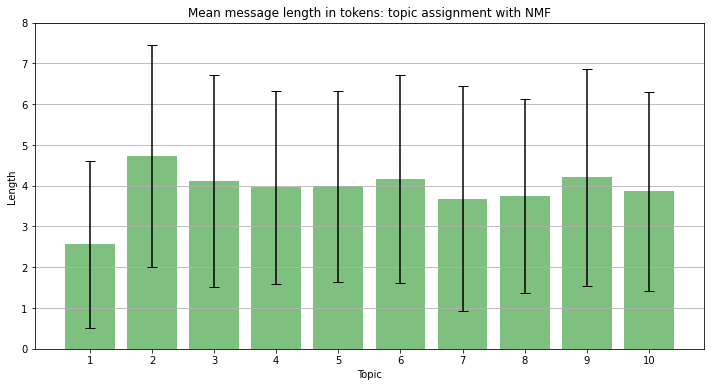

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(1,11), means2, color='Green', ecolor='Black', yerr=sd2, alpha=0.5, width=0.8, capsize=5)
ax.set_xticks(topics)
ax.set_yticks(np.arange(0,9))
ax.set_title('Mean message length in tokens: topic assignment with NMF')
ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.yaxis.grid(True);

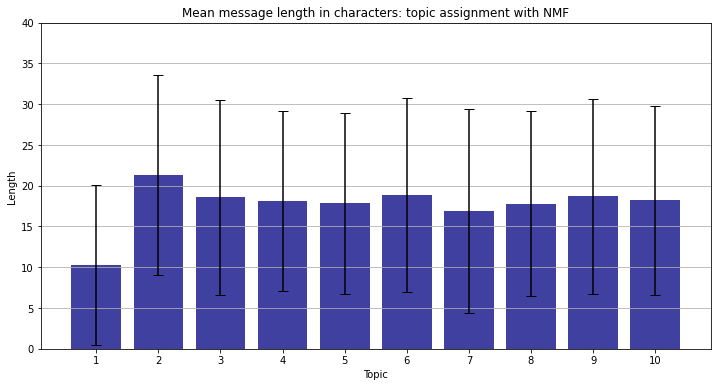

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(1,11), char2, color='Navy', ecolor='Black', yerr=charsd2, alpha=0.75, width=0.8, capsize=5)
ax.set_xticks(topics)
ax.set_yticks(np.arange(0,41,5))
ax.set_title('Mean message length in characters: topic assignment with NMF')
ax.set_xlabel('Topic')
ax.set_ylabel('Length')
ax.yaxis.grid(True);

In [55]:
polarities2 = corpus.drop(columns=['message', 'tokens', 'wordlength', 'charlength', 'LDA topic'])

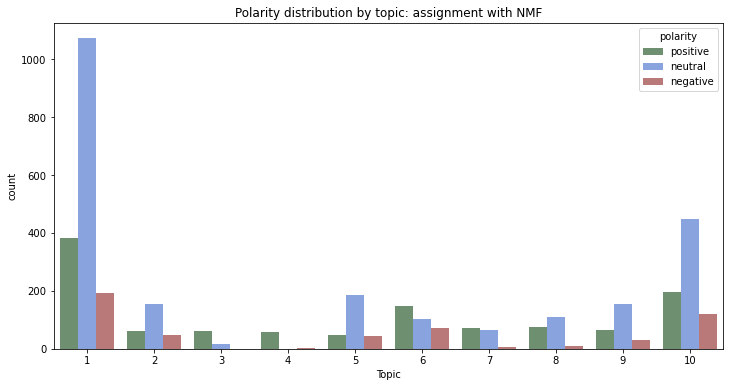

In [56]:
plt.figure(figsize=(12,6))
sns.countplot(data=polarities2, x='NMF topic', hue='polarity', 
              hue_order=['positive', 'neutral', 'negative'], palette=palette1)
plt.title('Polarity distribution by topic: assignment with NMF')
plt.xlabel('Topic');

In [57]:
#Topics 1 and 10 have been assigned noticeably more messages
#and some topics have nearly no messages

In [58]:
#The only even vaguely salient observation I feel I can make here is the
#higher proportion of positive messages in topic 6 and the fact that its
#top 20 words contain 'fun', 'friend', 'good', 'gift'

In [59]:
topic_counts = corpus['NMF topic'].value_counts()
for i in range(1,11):
    print(f"Topic {i}:", topic_counts[i], "messages")

Topic 1: 1649 messages
Topic 2: 262 messages
Topic 3: 78 messages
Topic 4: 61 messages
Topic 5: 279 messages
Topic 6: 322 messages
Topic 7: 142 messages
Topic 8: 195 messages
Topic 9: 249 messages
Topic 10: 763 messages


In [60]:
#Why is this distribution the way that it is?

In [61]:
#Once again, based on the top 20 words for each topic, no topic has cohesive,
#specific subject matter, messages that all relate to some concept

In [62]:
#There is also no similarity between LDA and NMF in terms of the top 20 words
#for each of the 10 topics